In [1]:
from qiskit import *
from qiskit.tools.monitor import job_monitor

import numpy as np
import pylab as pl

import networkx as nx
from qiskit.visualization import *
from scipy import optimize as opt
from qaoa import *
import os
from matplotlib import rc
font = {'size' : 16}
rc('font', **font);
rc('text', usetex=True)

import sys
sys.path.append('../')

from qiskit_utilities.utilities import *

### Let us import and draw the graph

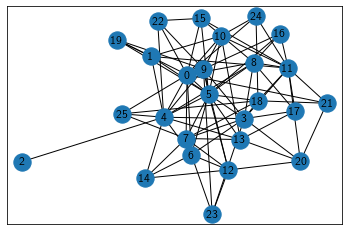

In [2]:
G = nx.read_gml("../data/sample_graphs/w_ba_n26_k4_0.gml")
pos = nx.spring_layout(G)
nx.draw_networkx(G,apos=pos)

### Draw the histogram of number of solutions for value of cost function

In [3]:
if os.path.isfile("../data/sample_graphs/w_ba_n26_k4_0_costs.npy"):
    costs=np.load("../data/sample_graphs/w_ba_n26_k4_0_costs.npy")
else:
    costs=costsHist_MaxCut(G)
    np.save("../data/sample_graphs/w_ba_n26_k4_0_costs.npy", costs)

In [4]:
max_val=max(costs)
print("cost of optimal solution(s) = ", max_val)

cost of optimal solution(s) =  38.11808904821565


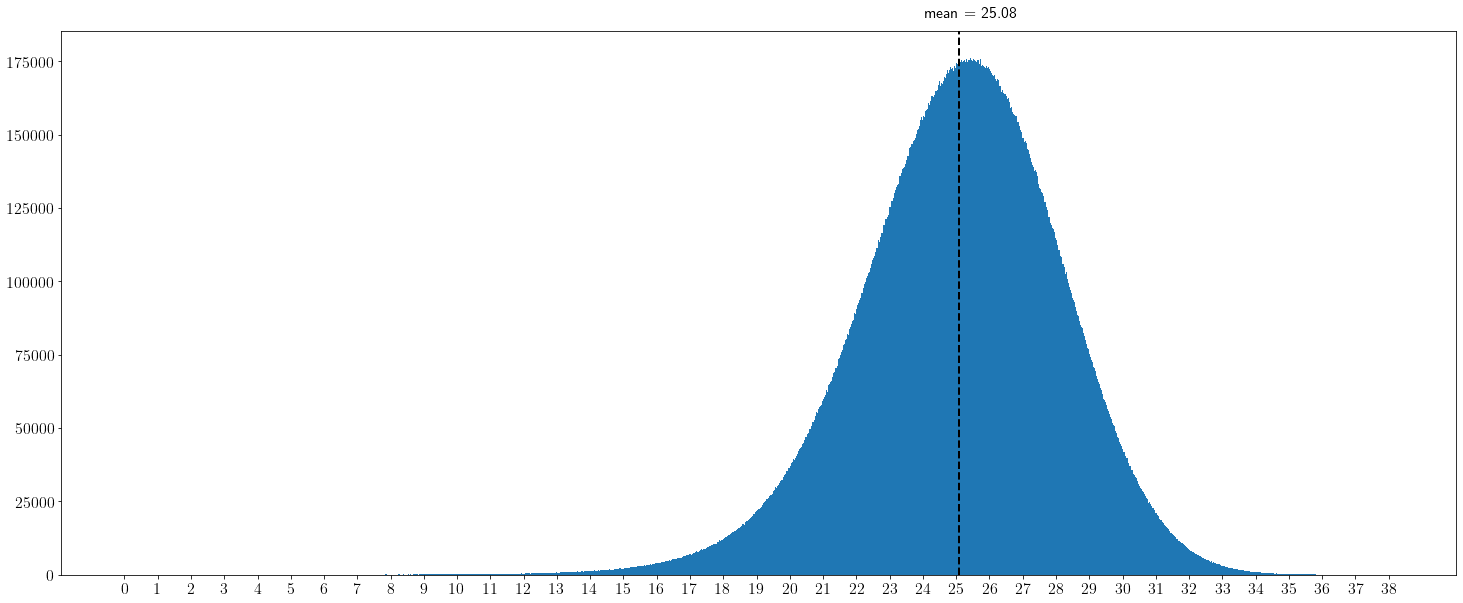

In [5]:
pl.figure(figsize=(25,10))
a=pl.hist(np.sort(costs), bins=2000)
min_ylim, max_ylim = pl.ylim()
max_ylim *=1.025
mean=np.mean(costs)
pl.axvline(mean, color='k', linestyle='dashed', linewidth=2)
a=pl.text(mean-1, max_ylim, 'mean = {:.2f}'.format(mean))
a=pl.xticks(np.arange(0, max_val, step=1))

### Only 0.6% of all solutions have a cost of 32 or higher

In [6]:
num_good_solutions=0
for i in range(0,costs.shape[0]):
    if costs[i]>=32:
        num_good_solutions+=1
print("There are", num_good_solutions, "solutions with cost 33 or higher, which is", num_good_solutions/2**26*100, "% of all solutions.")

There are 406966 solutions with cost 33 or higher, which is 0.6064265966415405 % of all solutions.


### There is only 1 optimal solution (modulo symmetry)

In [7]:
num_optimal_solutions=0
for i in range(0,costs.shape[0]):
    if costs[i]>=max_val:
        num_optimal_solutions+=1
print("There are", num_optimal_solutions, "solutions with maximum cost =",
      max_val ,", which is", num_optimal_solutions/2**26*100, "% of all solutions.")

There are 2 solutions with maximum cost = 38.11808904821565 , which is 2.9802322387695312e-06 % of all solutions.


### Calculate the energy landscape (this takes time)

In [8]:
#load IBMQ account
#IBMQ.save_account('yourAPItoken')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

backend_sim=provider.get_backend('ibmq_qasm_simulator')

In [9]:
version=1
circuits=[]
n=24
m=12
beta_max=2*np.pi
gamma_max=np.pi
job_string="w_ba_n26_k4_0_"+str(n)+"x"+str(m)

if os.path.isfile("../data/sample_graphs/"+job_string+"_Elandscape_v1.npy"):
    Elandscape_v1 = np.load("../data/sample_graphs/"+job_string+"_Elandscape_v1.npy")
else:
    results = read_results(job_string)
    if results == None:
        for beta in np.linspace(0,beta_max,n):
            for gamma in np.linspace(0,gamma_max,m):
                circuits.append(createCircuit_MaxCut(np.array((gamma,beta)),G,1,version))
        job_sim = start_or_retrieve_job(job_string, backend_sim, circuits, options={'shots' : 1024*2*2*2})
        job_monitor(job_sim)
        success = write_results(job_string, job_sim)
        results = read_results(job_string)
    Elandscape_v1 = -np.array(expectationValue_MaxCut(results,G))
    np.save("../data/sample_graphs/"+job_string+"_Elandscape_v1", Elandscape_v1)

### Define function for the optimizer

In [10]:
def getval(x, backend, depth=1, version=1, noisemodel=None):
    global it, values, gamma, beta
    job_string="w_ba_n26_k4_0_Nelder_Mead_"+str(it)
    results = read_results(job_string)
    if results == None:
        circ=createCircuit_MaxCut(x,G,depth,version)
        job_sim = start_or_retrieve_job(job_string, backend_sim, circ, options={'shots' : 1024*2*2*2})
        job_monitor(job_sim)
        success = write_results(job_string, job_sim)
        results = read_results(job_string)
    val=expectationValue_MaxCut(results,G)
    print(x)
    it+=1
    gamma[str(it)] = x[0]
    beta[str(it)] = x[1]
    values[str(it)] = val
    return -val[0]

### Run the optimization using Nelder-Mead (derivative free method)

[0.5 1.3]
[0.525 1.3  ]
[0.5   1.365]
[0.525 1.235]
[0.5375 1.17  ]
[0.55  1.235]
[0.5125  1.28375]
[0.5125  1.21875]
[0.521875  1.2796875]
[0.509375  1.3284375]
[0.51328125 1.30507813]
[0.50390625 1.30914062]
[0.49492187 1.32386719]
[0.49414062 1.30253906]
[0.48457031 1.30126953]
[0.4765625  1.34265625]
[0.50351562 1.29847656]
[0.49453125 1.31320312]
[0.50332031 1.29314453]
[0.48535156 1.32259766]
[0.48984375 1.31523437]
[0.48945312 1.30457031]
[0.49326172 1.31104492]
[0.49755859 1.29834961]
Optimization terminated successfully.
         Current function value: -26.157999
         Iterations: 11
         Function evaluations: 24
Optimal value= [0.49414062 1.30253906]


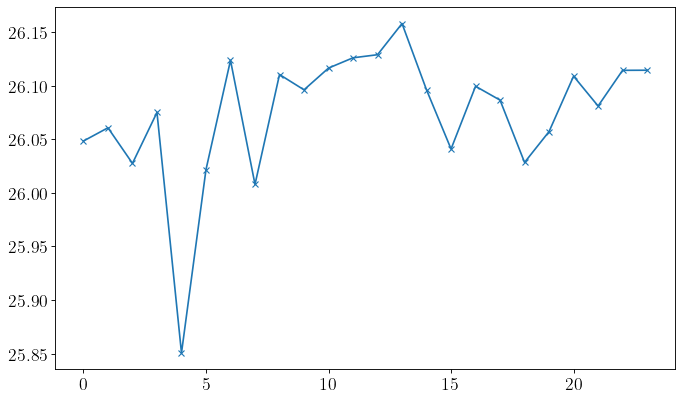

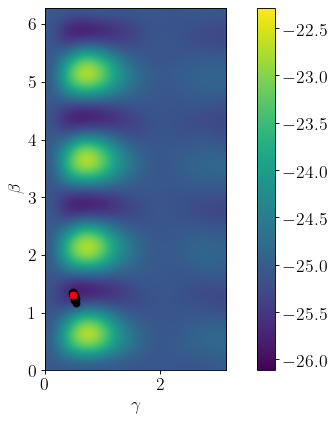

In [11]:
version=1
it=0
gamma={}
beta={}
values={}
xin=(.5,1.3)
out=opt.minimize(getval, x0=xin, method='Nelder-Mead',\
                 args=(backend_sim,1,version,None),\
             options={'xatol': 1e-2, 'fatol': 1e-1, 'disp': True})
print("Optimal value=",out.x)
f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
pl.plot(list(values.values()),'x-')

f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
pl.imshow(np.array(Elandscape_v1).reshape(n,m),interpolation='bicubic',origin='lower',extent=[0,gamma_max,0,beta_max])
pl.colorbar()
pl.xlabel(r'$\gamma$')
pl.ylabel(r'$\beta$')
pl.plot(list(gamma.values()),list(beta.values()),'ko-')
pl.plot(xin[0],xin[1],'or')
pl.plot(out.x[0],out.x[1],'xr')

### Pick the best solution and its parameters along the optimization path

In [12]:
tmp = max(values, key=values.get)
x_best=(gamma[tmp], beta[tmp])
print(values[tmp], x_best)

[26.157999122273115] (0.494140625, 1.3025390624999997)


### Calculate the average and maximum cost for the optimal parameters found with varying number of shots

In [13]:
num_shots=[]
bins_states={}
max_cost=[]
average_cost=[]
for i in range(4,14):
    ns=2**i
    num_shots.append(ns)
    jv1 = execute(createCircuit_MaxCut(x_best,G,1,version), backend_sim, shots=ns)
    bins_states[ns], mc, ac = bins_comp_basis(jv1.result().get_counts(),G)
    max_cost.append(mc)
    average_cost.append(ac)

### Calculate the average and maximum cost for random solutions with varying number of shots

In [14]:
import random
bins_states_rand={}
max_cost_rand=[]
average_cost_rand=[]
for i in range(4,14):
    ns=2**i
    tmp_states={}
    for j in range(0,ns):
        s = random.randint(0, ns - 1)
        binstring="{0:b}".format(s).zfill(26)
        y=[int(i) for i in binstring]
        c=cost_MaxCut(y,G)
        tmp_states[binstring]=c
    bins_states_rand[ns], mc, ac = bins_comp_basis(tmp_states,G)
    max_cost_rand.append(mc)
    average_cost_rand.append(ac)

### Plot comparison of random solution and QAOA

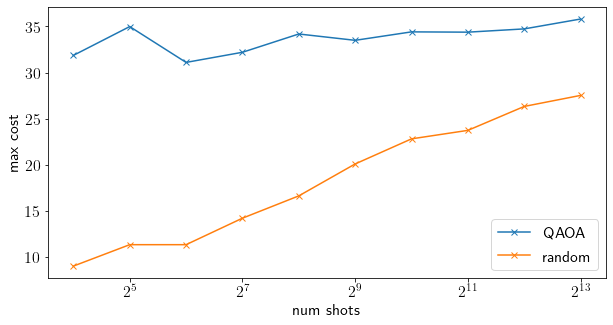

In [15]:
pl.figure(figsize=(10,5))
pl.semilogx(num_shots, max_cost,'x-', basex=2, label='QAOA')
pl.semilogx(num_shots, max_cost_rand,'x-', basex=2, label='random')
pl.legend()
pl.ylabel('max cost')
tmp=pl.xlabel('num shots')

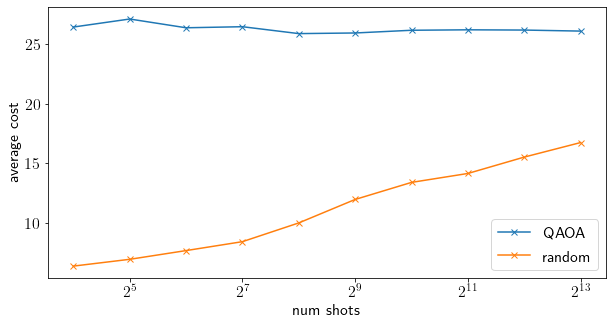

In [16]:
pl.figure(figsize=(10,5))
pl.semilogx(num_shots, average_cost,'x-', basex=2, label='QAOA')
pl.semilogx(num_shots, average_cost_rand,'x-', basex=2, label='random')
pl.legend()
pl.ylabel('average cost')
tmp=pl.xlabel('num shots')